# Advanced Big Data Analytics : Assignment 2 - Stock Price Prediction
## Gaurang Sadekar
### UNI : gss2147

This assignment requires us to predict the prices of stocks at 10:00am on Friday 11th March.  

The stocks we have to predict are traded on either the NYSE or the NASDAQ.  
**NYSE : **BAC, C, IBM, GE, T, MCD, NKE, TWTR  
**NASDAQ : **AAPL, TSLA

The most intuitive way to predict a stock price is using a linear regression model with historical stock price data.  
Other sources of data, such as Financial News and Tweets about that stock are also used by analysts, to possibly give some more deep, underlying trends and patterns which numbers by themselves may not be able to give.  
Fitting a linear regression model is the easy part. The hard part is deciding what features to use, in order to fit the data properly.  

When we choose features, a few factors have to be considered:
- How independent the features are from each other
- How they influence the target variable
- Are they or aren't they redundant
- Are we considering too many features, which might be resulting in overfitting
- Are we considering too few features, which might result in underfitting

There are many tradeoffs that need to be made:
One can use a large number of features to do the prediction.  
In the general case, using too many features causes overfitting, because we end up modeling all the noise in the data as well. Occam's Razor tells us that *'Among competing hypotheses, the one with the fewest assumptions should be selected'*. This translates when doing a prediction task to, 'if many models give the same you the same results, choose the one that is the simplest;.

The features can be repeated or redundant:
Redundant features add no value to the data set. Redundant features can be repeated features or features that are obtained by a linear combination of the other features. A good model is one in which all the features included are used properly, rather than including a number of features whose values have little or no effect on the prediction task at hand. Here, we don't have to deal with sparsity because we are choosing the features ourselves.


### The first linear regression model:

Just for experimentation sake, I first tried a very simple linear regression, that fit a straight line to one month of stock data.  
This model takes no features, it just plots prices as a function of the date.  
When we plot the price and the predictions of this simple model, we see that model is too simple to give even a reasonable estimate of the stock price. In this case, the **bias** of the model is very high, and it can't model any of the variations in the data.

This is the most basic kind of linear regression model. It predicts the market opening price as a function of the date, by fitting a line to the previous opening prices.  
The data used demonstrating is opening price data for 1 month, the month of February.  

This regression model does not take any **real** features into account, it just fits a straight line to previous opening prices.  
This model just finds the *slope* of stock prices, simply a function that says *increasing* or *decreasing*
The error of this extremely simple model is obviously very high. 

Seeing this, we know that we can only do better by choosing a proper set of features that can be modeled and fitted to a regression model.

In [29]:
%matplotlib inline
import csv
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from os import walk, path

In [2]:
dates = []
open_prices = []

def get_data(filename):
    with open(filename, 'r') as csvfile:
        csv_fr = csv.reader(csvfile)
        next(csv_fr) # skip the first row, which has all the column names
        for row in csv_fr:
            dates.append(int(row[0].split('-')[0]))
            open_prices.append(float(row[1]))
    return

In [11]:
get_data('goog.csv')

In [12]:
dates

[26, 25, 24, 23, 22, 19, 18, 17, 16, 12, 11, 10, 9, 8, 5, 4, 3, 2, 1]

In [13]:
linear_mod = linear_model.LinearRegression()

dates = np.reshape(dates, (len(dates), 1))

open_prices = np.reshape(open_prices, (len(open_prices), 1))

linear_mod.fit(dates, open_prices)

/Users/gaurang/Code/spring16/ABDA/venv/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
predict_price = linear_mod.predict(29)
predict_price

array([[ 680.9255198]])

In [15]:
linear_mod.intercept_

array([ 728.93081909])

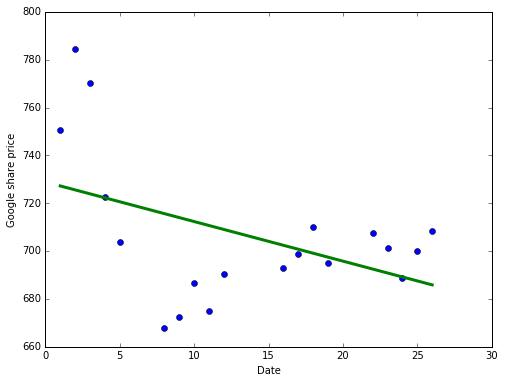

In [17]:
figure, ax = plt.subplots(figsize=(8,6))
ax.plot(dates, open_prices,'o')
ax.plot(dates, linear_mod.predict(dates), linewidth=3)
plt.xlabel('Date')
plt.ylabel('Google share price')

## Fitting a multivariate regression model:
The stock price prediction problem is perfectly suited for fitting a multivariate regression model.  
We can fit a multivariate linear regression model that uses informative features and a large amount of data to predict the stock prices.
Given enough features, a linear regression model can fit a wide variety of curves
Once we have a good feature set selected, it is a matter of fitting the model and making a prediction.  
The main question here then, is what features to use for this prediction task.

I collected open, close, high and low prices, and the volume of shares traded every day from Google Finance.  

I tried various combinations of these features, keeping the price of the next day as the target and using the other fields as input features:  
- Adding additional polynomial features : Causes the mean squared error of the model to increase as it overfits the data  
- Not using volume as a feature : Reduces the prediction accuracy (slightly)
- Only using previous day's close price : Model is not sensitive enough to the data, but still fairly accurate.

Another observation is that the close price of the previous day is the most important feature according to the model coefficients, for all the stocks.  
After trying out such combinations, I settled on the final model, which uses the high, low and close price, and the volume traded on a particular day as indicators, to predict the opening price of the stock on the next day.  

The code for the model is all developed using Python's excellent `scikit-learn` Machine Learning library.  
We use the `LinearRegression` class, which supports all varieties of linear regressions, and their various regularizations.  
The default regularization used is the l2-norm.  
All models in `sklearn` have a consistent interface, a method `fit()` which creates the model and a method `predict()` which predicts the output parameter for unseen values. 

In [62]:
def get_data(filename):
    with open(filename, 'r') as csvfile:
        csv_fr = csv.reader(csvfile)
        next(csv_fr) # skip the first row, which has all the column names
        data = []
        open_prices = []
        for row in csv_fr:
            row_date = int(row[0].split('-')[0])
            open_price = float(row[1])
            high = float(row[2])
            low = float(row[3])
            close= float(row[4])
            volume = int(row[5])
            datapoint = [row_date, high, low, close, volume]
            data.append(datapoint)
            open_prices.append(open_price)
        return data, open_prices

In [83]:
# format the data, realign the fields etc
def format_data(data, open_prices):
    predict_on = data[0]
    # data_predict_on = predict_on[0]
    predict_on = predict_on[1:]
    data = data[1:]
    open_prices = open_prices[:-1]
    reg_data = np.asarray(data)
    dates = reg_data[:, 0]
    reg_data = reg_data[:, 1:]
    prices = np.reshape(open_prices, len(open_prices), 1)
    return reg_data, prices, predict_on

In [118]:
def fit_and_predict_regression(reg_data, prices, predict_on):
    # fit a linear regression
    linear_mod = linear_model.LinearRegression()
    linear_mod.fit(reg_data, prices)
    predicted_prices = linear_mod.predict(reg_data)
    predict_price = linear_mod.predict(np.array(predict_on).reshape(1, -1))
    return (predict_price, predicted_prices)

In [119]:
predict_on

[17.77, 16.38, 16.61, 33207611]

AAPL 101.18
BAC 13.32
C 41.52
GE 29.88
IBM 140.53
MCD 119.96
NKE 59.08
T 38.22
TSLA 205.56
TWTR 16.52


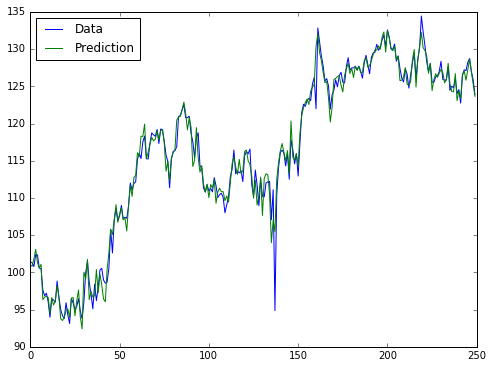

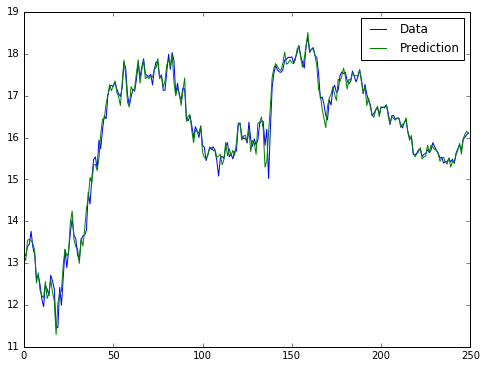

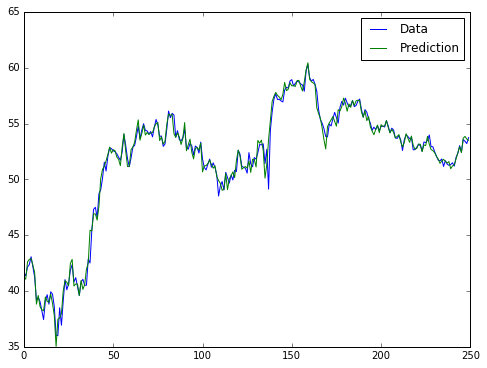

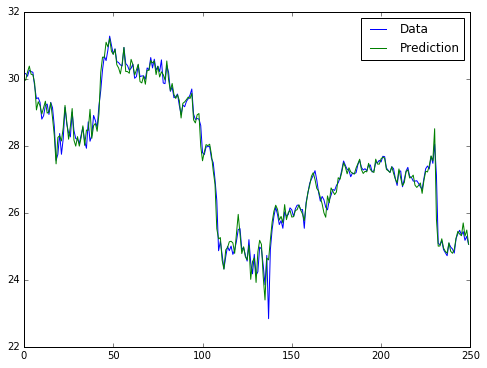

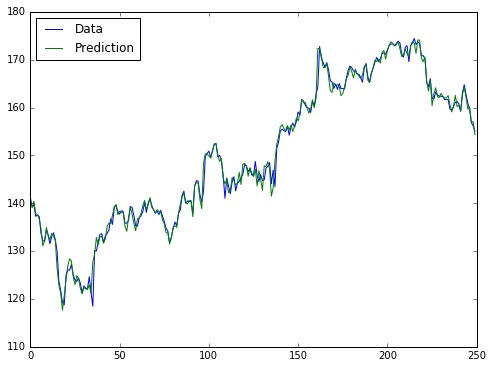

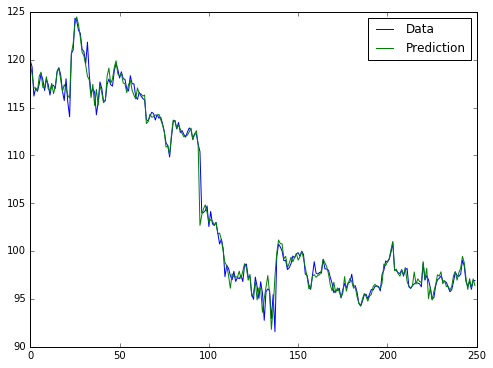

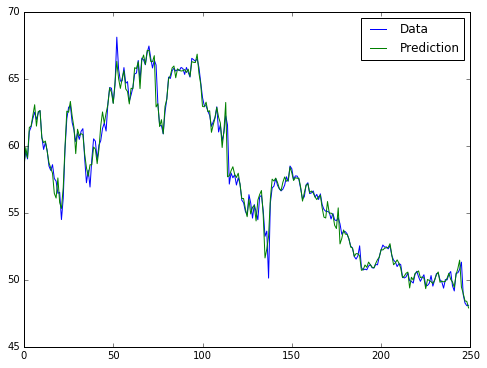

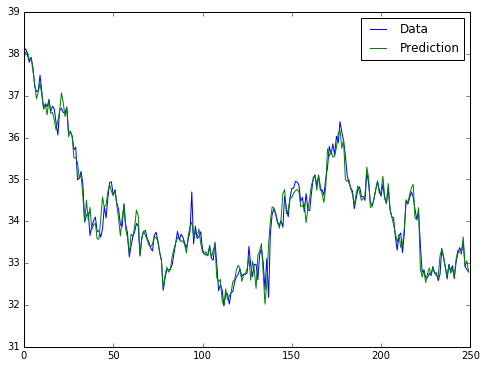

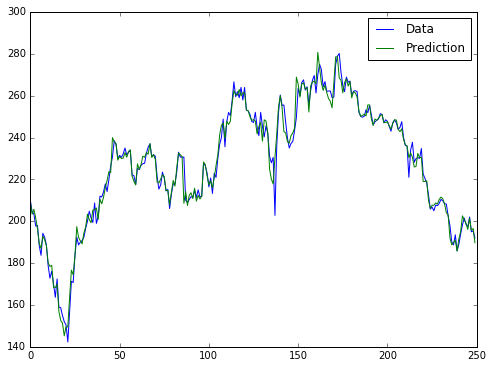

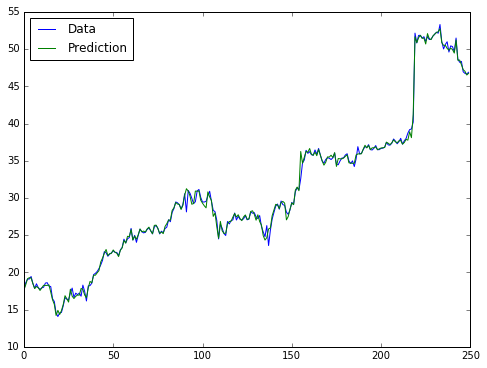

In [120]:
from sklearn.metrics import mean_squared_error
for root, _, filenames in walk("./stock_data/", topdown=True):
    for name in sorted(filenames):
        root_path = path.join(root,name)
        stock_name = name[:-4]
        data, open_prices = get_data(root_path)
        reg_data, prices, predict_on = format_data(data, open_prices)
        
        predict_price, predicted_prices = fit_and_predict_regression(reg_data, prices, predict_on)
        print stock_name, round(predict_price, 2)
        mse = mean_squared_error(prices, predicted_prices)
        figure, ax = plt.subplots(figsize=(8,6))
        ax.plot(range(len(prices)),  prices, 'b-', label='Data')
        ax.plot(range(len(prices)), predicted_prices, 'g-', label='Prediction')
        ax.legend(loc='best')

By plotting the actual prices vs the regression prediction, we see that this linear regression model matches the actual prices very well.  
The blue plot is the actual opening prices and the green plot is the prices predicted by the model.  
Since this is the training data itself, we expect the error to be low, however as we can see, this is a really good fit of the data.  
All these plots are actually in reverse because the downloaded the data, it is in the order of latest date first. The plots are all backwards from 252 days ago until 0 days ago.  

In [117]:
linear_mod.coef_

array([ -5.35561478e-02,   1.14350504e-01,   9.42905423e-01,
        -3.10270552e-09])

Just arbitrarily picking one set of linear coefficients, we see that the closing price is the most influential feature among all those that we have picked, as compared to which the high and low price are not as important.  
However, simply trying to predict opening price of the next day as a function of the closing price of the previous day does not work as well as including high and low as well, because the model is less sensitive to variance.

## Fitting a Time Series to the data

In [1]:
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt

/Users/gaurang/Code/spring16/ABDA/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [53]:
dateparse = lambda dates : pd.datetime.strptime(dates, '%d-%b-%y')
# parse dates to convert the data into a time series
data = pd.read_csv('./stock_data/AAPL.csv', index_col=0, date_parser=dateparse)

In [55]:
data.head()

,Open,High,Low,Close,Volume
﻿Date,,,,,
2016-03-10,101.41,102.24,100.15,101.17,33513577
2016-03-09,101.31,101.58,100.27,101.12,27130729
2016-03-08,100.78,101.76,100.40,101.03,31274161
2016-03-07,102.39,102.83,100.96,101.87,35828909
2016-03-04,102.37,103.75,101.37,103.01,45936485


In [56]:
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [57]:
# target variable
prices = data['Open']

In [58]:
prices.head()

﻿Date
2016-03-10    101.41
2016-03-09    101.31
2016-03-08    100.78
2016-03-07    102.39
2016-03-04    102.37
Name: Open, dtype: float64

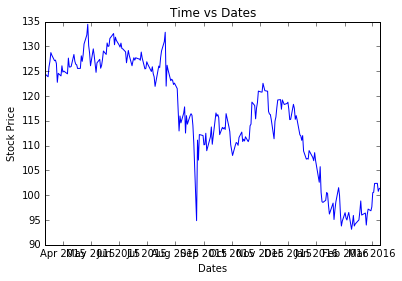

In [61]:
plt.plot(prices)
plt.xlabel('Dates')
plt.ylabel('Stock Price')
plt.title('Time vs Dates')

In [67]:
mean_price = prices.mean()
stationary_prices = prices - mean_price
# wow, just subtracting the mean totally centered the data

In [68]:
stationary_prices.mean()

1.4041003862032259e-14

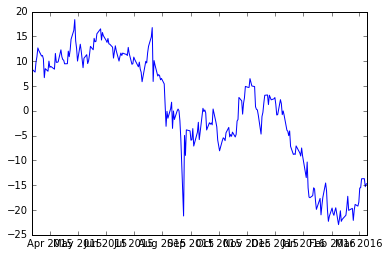

In [69]:
plt.plot(stationary_prices)